In [1]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import mne


In [2]:
data_path =  'D:\projects\WM_GRID\DATA\mg99a'
cal_path = 'D:\projects\WM_GRID\DATA\ctc'
sss_path = 'D:\projects\WM_GRID\DATA\sss'
file_name = 'mg99a01'
raw_fname_in = op.join(data_path, file_name + '.fif')
raw = mne.io.read_raw_fif(
    raw_fname_in,
    allow_maxshield=True,
    preload=False,
    verbose=True)

Opening raw data file D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif...


C:\Users\qiaol\AppData\Local\Temp\ipykernel_27692\2854599378.py:6: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a\mg99a01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 72000 ... 946999 =     72.000 ...   946.999 secs
Ready.


In [9]:
crosstalk_file = op.join(cal_path, 'ct_sparse.fif')
fine_cal_file = op.join(sss_path, 'sss_cal.dat')
print(fine_cal_file)
print(crosstalk_file)

D:\projects\WM_GRID\DATA\sss\sss_cal.mat
D:\projects\WM_GRID\DATA\ctc\ct_sparse_leipzig_061201.fif


In [15]:
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
crosstalk_file = op.join(cal_path, 'ct_sparse.fif')
fine_cal_file = op.join(sss_path, 'sss_cal.dat')
# Detect bad channels
raw.info['bads'] = []
raw_check = raw.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 874999  =      0.000 ...   874.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    4.8s finished


Scanning for bad channels in 175 intervals (5.0 sec) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 2): MEG1241 MEG2641
        Interval   2:    5.000 -    9.999
            Flat ( 2): MEG1241 MEG2641
        Interval   3:   10.000 -   14.999
            Flat ( 2): MEG1241 MEG2641
        Interval   4:   15.000 -   19.999
            Flat ( 2): MEG1241 MEG2641
        Interval   5:   20.000 -   24.999
            Flat ( 2): MEG1241 MEG2641
        Interval   6:   25.000 -   29.999
            Flat ( 2): MEG1241 MEG2641
        Interval   7:   30.000 -   34.999
            Flat ( 2): MEG1241 MEG26

In [16]:
print('noisy =', auto_noisy_chs)
print('flat = ', auto_flat_chs)
raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', raw.info['bads'])

noisy = ['MEG0413']
flat =  ['MEG1241', 'MEG2641']
bads = ['MEG0413', 'MEG1241', 'MEG2641']


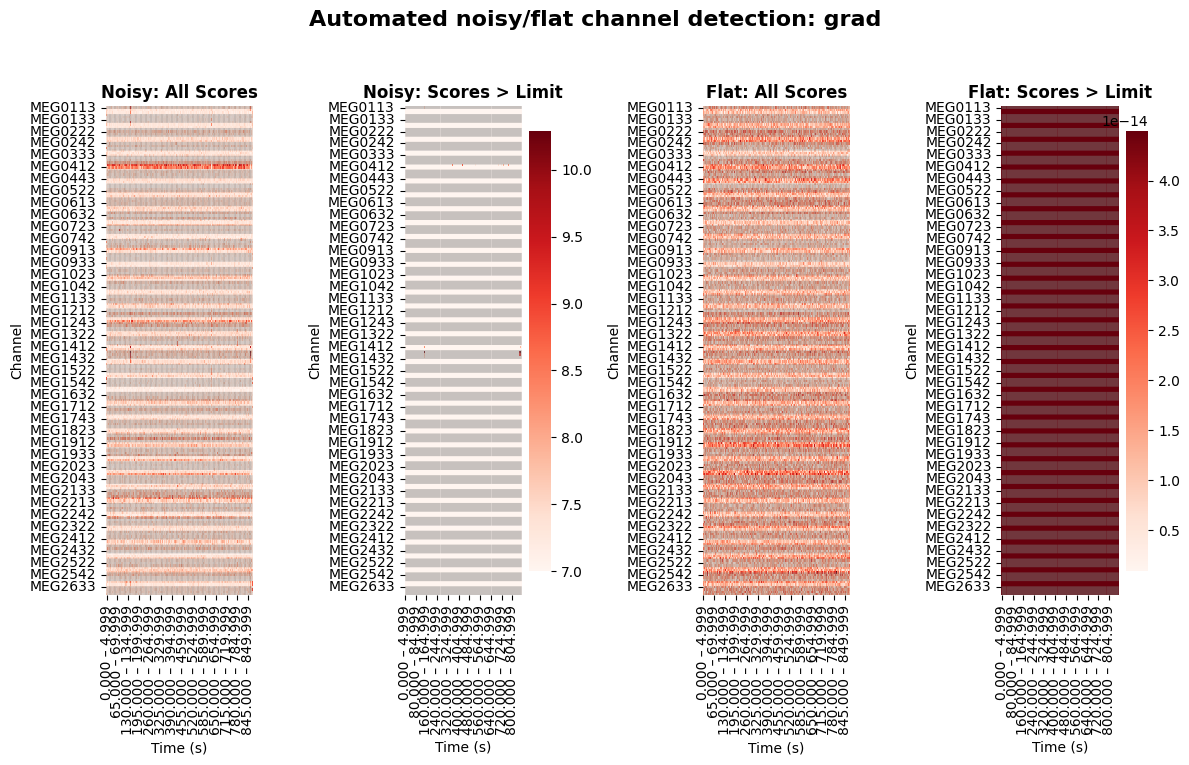

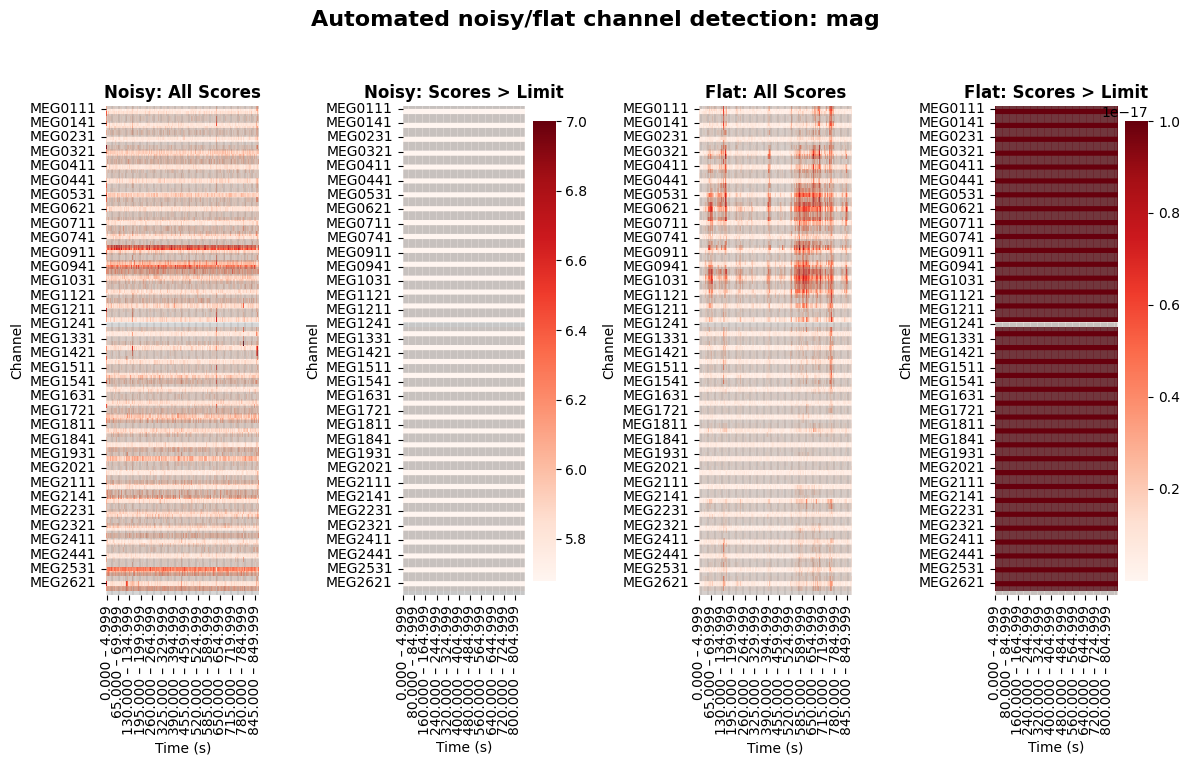

In [18]:
# Visualize the scoring used to classify channels as noisy or flat
import seaborn as sns
def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

ch_type = 'grad'
fig = viz_badch_scores(auto_scores, ch_type)

ch_type = 'mag'
fig = viz_badch_scores(auto_scores, ch_type)


In [19]:
# Fix Elekta magnetometer coil types
raw.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


<Raw | mg99a01.fif, 310 x 875000 (875.0 s), ~6.5 MB, data not loaded>

In [21]:
raw_sss = mne.preprocessing.maxwell_filter(
    raw,
    cross_talk=crosstalk_file, 
    calibration=fine_cal_file,
    st_duration=None,
    #coord_frame="meg", #only for empy room, comment it if using HPI
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0413', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 86.6 mm
    Using origin -1.8, 7.2, 49.6 mm in the head frame
        Using 89/95 harmonic components for    0.000  (74/80 in, 15/15 out)
    Loading raw data from disk
    Processing 87 data chunks
[done]


Using matplotlib as 2D backend.


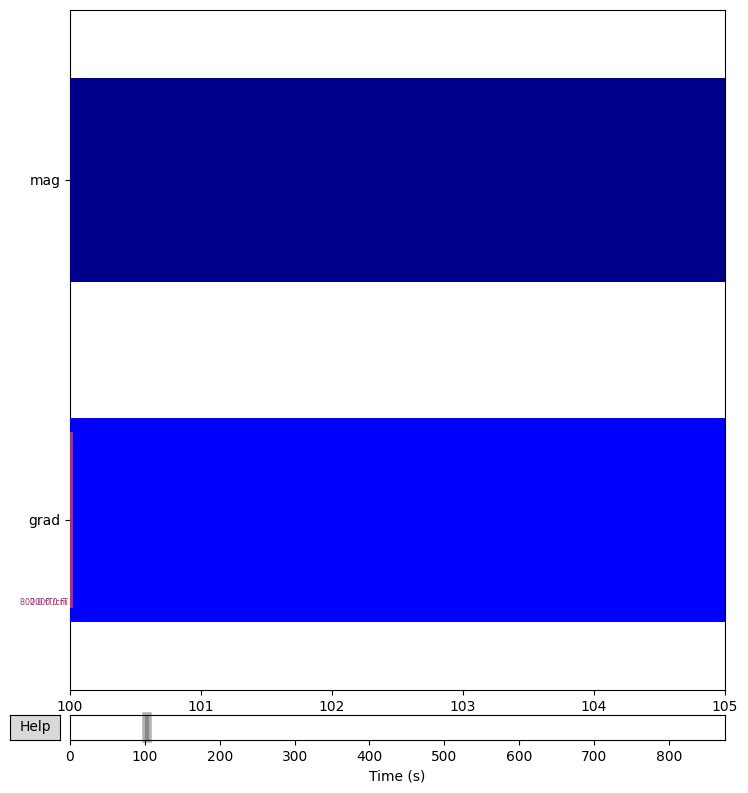

Effective window size : 0.256 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [22]:
fig = raw_sss.copy().pick(['meg']).plot(duration=5,
                                        start=100,
                                        butterfly=True)
fig1 = raw_sss.compute_psd(picks = ['meg'],fmin = 1,fmax = 100).plot()

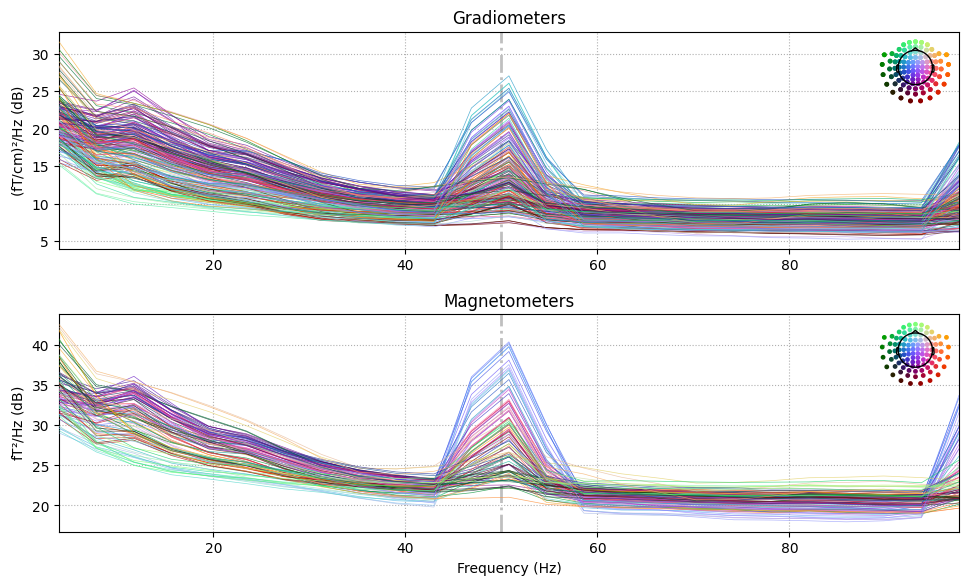

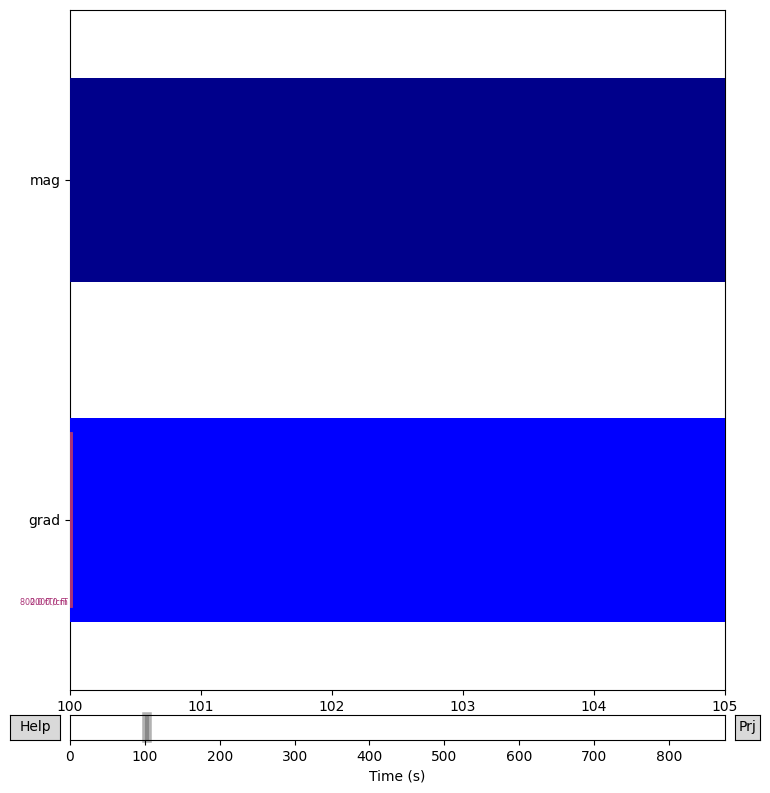

Effective window size : 0.256 (s)


d:\projects\WM_GRID\venv\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [23]:
fig = raw.copy().pick(['meg']).plot(duration=5,
                                    start=100,
                                    butterfly=True)
plt.close()
fig1 = raw.compute_psd(picks = ['meg'],fmin = 1,fmax = 100).plot()

In [24]:
method = 'sss'
file_name = 'mg99a01'
out_path = 'D:\projects\WM_GRID\DATA\mg99a_out'
fname_out = op.join(out_path,
                    file_name + '_' + method + '.fif')
raw_sss.save(fname_out, overwrite=True)

Overwriting existing file.
Writing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif


C:\Users\qiaol\AppData\Local\Temp\ipykernel_27692\1427141690.py:6: RuntimeWarning: This filename (D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_sss.save(fname_out, overwrite=True)


Closing D:\projects\WM_GRID\DATA\mg99a_out\mg99a01_sss.fif
[done]


In [47]:
raw_sss.channel

['MEG0113',
 'MEG0112',
 'MEG0111',
 'MEG0122',
 'MEG0123',
 'MEG0121',
 'MEG0132',
 'MEG0133',
 'MEG0131',
 'MEG0143',
 'MEG0142',
 'MEG0141',
 'MEG0213',
 'MEG0212',
 'MEG0211',
 'MEG0222',
 'MEG0223',
 'MEG0221',
 'MEG0232',
 'MEG0233',
 'MEG0231',
 'MEG0243',
 'MEG0242',
 'MEG0241',
 'MEG0313',
 'MEG0312',
 'MEG0311',
 'MEG0322',
 'MEG0323',
 'MEG0321',
 'MEG0333',
 'MEG0332',
 'MEG0331',
 'MEG0343',
 'MEG0342',
 'MEG0341',
 'MEG0413',
 'MEG0412',
 'MEG0411',
 'MEG0422',
 'MEG0423',
 'MEG0421',
 'MEG0432',
 'MEG0433',
 'MEG0431',
 'MEG0443',
 'MEG0442',
 'MEG0441',
 'MEG0513',
 'MEG0512',
 'MEG0511',
 'MEG0523',
 'MEG0522',
 'MEG0521',
 'MEG0532',
 'MEG0533',
 'MEG0531',
 'MEG0542',
 'MEG0543',
 'MEG0541',
 'MEG0613',
 'MEG0612',
 'MEG0611',
 'MEG0622',
 'MEG0623',
 'MEG0621',
 'MEG0633',
 'MEG0632',
 'MEG0631',
 'MEG0642',
 'MEG0643',
 'MEG0641',
 'MEG0713',
 'MEG0712',
 'MEG0711',
 'MEG0723',
 'MEG0722',
 'MEG0721',
 'MEG0733',
 'MEG0732',
 'MEG0731',
 'MEG0743',
 'MEG0742',
 'ME

In [45]:
eog_events = mne.preprocessing.find_eog_events(raw,event_id=998, l_freq=1, h_freq=10, filter_length='10s', ch_name=None, tstart=0, reject_by_annotation=False, thresh=None, verbose=None)

RuntimeError: No EOG channel(s) found

In [31]:
eog_events = mne.preprocessing.create_eog_epochs(raw_sss)
onsets = (eog_events[:, 0] - raw.first_samp) / raw.info['sfreq'] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ['Blink'] * len(eog_events)
            # Annotate events
annot_blink = mne.Annotations(
            onsets, 
            durations,
            descriptions)
                # orig_time=raw.info['meas_date'])
            
            # Add blinks to annotations list


Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 3 (average pulse 0 / min.)
Not setting metadata
3 matching events found
No baseline correction applied
Using data from preloaded Raw for 3 events and 1001 original time points ...
1 bad epochs dropped


In [48]:
from mne.preprocessing import annotate_muscle_zscore
# Notch filter
raw_muscle = raw_sss.copy().notch_filter([50, 100])
threshold_muscle = 10
annot_muscle, scores_muscle = annotate_muscle_zscore(
            raw_muscle, 
            ch_type="mag", 
            threshold=threshold_muscle, 
            min_length_good=0.2,
            filter_freq=[110, 140])


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    5.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 102 out of 102 | elapsed:    3.6s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [50]:
fig1, ax = plt.subplots()
ax.plot(raw.times, scores_muscle)
ax.axhline(y=threshold_muscle, color='r')
ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')
plt.close()

[Text(0.5, 0, 'time, (s)'),
 Text(0, 0.5, 'zscore'),
 Text(0.5, 1.0, 'Muscle activity')]